In [56]:
from pathlib import Path
from functools import partial
from abc import ABC, abstractmethod
from multiprocessing import Pool

import json
import random
import colorsys
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from math import sqrt
from itertools import chain
from collections import Counter, defaultdict, OrderedDict

from IPython.display import display, Image
from IPython.core.display import HTML 

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import PIL as pil
import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.pipeline import make_pipeline, make_union, Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix as sk_cmatrix
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from skimage.restoration import estimate_sigma
from ml_metrics import quadratic_weighted_kappa, rmse

DATA_HOME = Path('../input')
PF_HOME = DATA_HOME / 'petfinder-adoption-prediction'

IS_LOCAL = Path('IS_LOCAL').exists()
LABEL_NUM = 5

DEFAULT = 0
pd.set_option('display.max_rows', 1000)

print(f'IS_LOCAL = {IS_LOCAL}')

pd.set_option('display.max_columns', None)
SEED = 7
np.random.seed(SEED)
CATEGORY_SUFFIX = '@c'

IS_LOCAL = True


In [2]:
def greedy_group_k_fold_stratified(X, y, groups, k=5):
    y_counts_per_group = defaultdict(lambda: np.zeros(LABEL_NUM))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(LABEL_NUM))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(LABEL_NUM):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)

    for g, y_counts in sorted(y_counts_per_group.items(), key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [52]:
def by_indices(data, indices):
        if isinstance(data, pd.DataFrame):
            return data.iloc[indices]
        if isinstance(data, list):
            return [data[i] for i in indices]
        return data[indices]     

def explode(df, col, fillna=None):
    ret = None
    
    col_name = col if isinstance(col, str) else '_'.join(col)
    
    new_cols = pd.DataFrame(({f'{col_name}_{k}': v for k, v in d.items()} 
                             for idx, d in df[col].iteritems()))
    if fillna is not None:
        new_cols = new_cols.fillna(fillna)
    new_cols.index = df.index
    
    ret = pd.concat([df, new_cols], axis=1)
    del ret[col]
    return ret

def run_cv_model(
    name, 
    train_y, train_rescue_ids,
    train_x, train_ids,
    test_x, test_ids, 
    reg_model_factory, qwk_model_factory, k=5
):
    def format_stats(mean: float, std: float) -> str:
        return f'{mean:.3f} ± {std:.3f}'

    def save_predictions(pred_y):
        if IS_LOCAL:
            preds_dir = Path('predictions')
            preds_path = preds_dir / f'{name}.csv'
            checks_num = 0
            while preds_path.exists():
                checks_num += 1
                new_file_name = f'{name}-{checks_num}.csv'
                preds_path = preds_dir / new_file_name
            print(f'Saving to path `{preds_path}`')
        else:
            preds_path = 'submission.csv'

        submission = pd.DataFrame({'PetID': test_ids, 'AdoptionSpeed': pred_y.astype(np.int32)})
        submission.to_csv(preds_path, index=False)
    
    def get_formatted_cv_evals(dev_rmse_scores, val_rmse_scores, dev_qwk_scores, val_qwk_scores):
        data = []
        indices = []
        for fold_ind, scores in enumerate(zip(
            dev_rmse_scores, val_rmse_scores, dev_qwk_scores, val_qwk_scores
        )):
            data.append([f'{s:.3f}' for s in scores])
            indices.append(f'{name} - fold {fold_ind}')
        return pd.DataFrame(data, index=indices, columns=[
            'dev cv rmse', 'val cv rmse', 'dev cv qwk', 'val cv qwk'])
    
    def get_distr(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(5)]

    dev_rmse_scores = []
    dev_qwk_scores = []
    
    val_rmse_scores = []
    val_qwk_scores = []

    pred_train_y_reg = np.zeros(len(train_y))
    pred_test_y_reg = 0
    
    models = []
    qwk_models = []
    
#     splits = StratifiedKFold(n_splits=k, random_state=7, shuffle=True).split(train_x, train_y)
#     splits = GroupKFold(n_splits=k).split(train_x, train_y, groups=train_rescue_ids)
#     splits = group_k_fold_stratified(train_x, train_y, groups=train_rescue_ids, k=5)
    splits = greedy_group_k_fold_stratified(train_x, train_y, groups=train_rescue_ids, k=5)

    for fold, (dev_indices, val_indices) in enumerate(splits):
        g1 = set(by_indices(train_rescue_ids, dev_indices))
        g2 = set(by_indices(train_rescue_ids, val_indices))
        
        assert len(g1 & g2) == 0
        
        dev_x, val_x = by_indices(train_x, dev_indices), by_indices(train_x, val_indices)
        dev_y, val_y = by_indices(train_y, dev_indices), by_indices(train_y, val_indices)
        dev_ids, val_ids = by_indices(train_ids, dev_indices), by_indices(train_ids, val_indices)
        
        display(pd.DataFrame([
            [f'{len(dev_y) / len(train_y):.2%}'] + get_distr(dev_y),
            [f'{len(val_y) / len(train_y):.2%}'] + get_distr(val_y)
        ], index=[f'fold {fold}: dev_y', f'fold {fold}: val_y'], 
           columns=['# of examples'] + list(range(5))
        ))

        model = reg_model_factory()
        model.fit(dev_x, dev_ids, dev_y, val_x, val_ids, val_y)
        
        pred_dev_y_reg = model.predict(dev_x, dev_ids, is_train=True)
        dev_rmse_scores.append(rmse(dev_y, pred_dev_y_reg))
        
        pred_val_y_reg = model.predict(val_x, val_ids, is_train=True)
        val_rmse_scores.append(rmse(val_y, pred_val_y_reg))

        qwk_model = qwk_model_factory()
        qwk_model.fit(pred_dev_y_reg, dev_ids, dev_y, pred_val_y_reg, val_ids, val_y)
        
        pred_dev_y = qwk_model.predict(pred_dev_y_reg, dev_ids, is_train=True)
        dev_qwk_scores.append(quadratic_weighted_kappa(dev_y, pred_dev_y))
        
        pred_val_y = qwk_model.predict(pred_val_y_reg, val_ids, is_train=True)
        val_qwk_scores.append(quadratic_weighted_kappa(val_y, pred_val_y))

        pred_train_y_reg[val_indices] = pred_val_y_reg
        pred_test_y_reg += model.predict(test_x, test_ids, is_train=False)
        
        models.append(model)
        qwk_models.append(qwk_model)

    pred_test_y_reg /= k

    qwk_model = qwk_model_factory()
    qwk_model = qwk_model.from_models(qwk_models)

    pred_train_y = qwk_model.predict(pred_train_y_reg, train_ids, is_train=True)
    train_qwk = quadratic_weighted_kappa(train_y, pred_train_y)
    
    display(get_formatted_cv_evals(dev_rmse_scores, val_rmse_scores, dev_qwk_scores, val_qwk_scores))

    display(pd.DataFrame([[
        '',
        f'{np.mean(dev_rmse_scores):.3f}',
        f'{np.std(dev_rmse_scores):.3f}',
        f'{np.mean(val_rmse_scores):.3f}',
        f'{np.std(val_rmse_scores):.3f}',
        f'{np.mean(dev_qwk_scores):.3f}',
        f'{np.std(dev_qwk_scores):.3f}',
        f'{np.mean(val_qwk_scores):.3f}',
        f'{np.std(val_qwk_scores):.3f}',
        f'{train_qwk:.3f}'
    ]], index=[name], columns=[
        'params', 
        'dev cv rmse (avg)', 'dev cv rmse (std)', 'val cv rmse (avg)', 'val cv rmse (std)',
        'dev cv qwk (avg)', 'dev cv qwk (std)', 'val cv qwk (avg)', 'val cv qwk (std)', 
        'train set qwk']))
    
    pred_test_y = qwk_model.predict(pred_test_y_reg, test_ids, is_train=False)
    
    display(pd.DataFrame([
        get_distr(train_y),
        get_distr(pred_train_y),
        get_distr(pred_test_y),
    ], index=['train_y', 'pred_train_y', 'pred_test_y'], columns=list(range(5))))
    
    save_predictions(pred_test_y)
    
    conf_matrix = pd.DataFrame(
        sk_cmatrix(train_y, pred_train_y), index=list(range(5)), columns=list(range(5)))
    ax = sns.heatmap(conf_matrix, annot=True, fmt='d')
    ax.set_xlabel('y_pred')
    ax.set_ylabel('y_true')
    display(ax)
    
    return OrderedDict([
        ('models',            models),
        ('qwk_models',        qwk_models),
        ('pred_train_y_reg',  pred_train_y_reg),
        ('pred_train_y',      pred_train_y),
        ('pred_test_y_reg',   pred_test_y_reg),
        ('pred_test_y',       pred_test_y),
    ])


def display_train_example(idx):
    data_id = train_ids[idx]
    data = train_x.iloc[idx].to_dict()
    df = pd.DataFrame([
        ('Type', {1: 'dog', 2: 'cat'}[data['Type']]),
        ('Name', data['Name']),
        ('Age', data['Age']),
        ('Breed1', breed_labels_map.get(data['Breed1'], "MISSING")),
        ('Breed2', breed_labels_map.get(data['Breed2'], "MISSING")),
        ('Gender', {1: 'Male', 2: 'Female', 3: 'Mixed'}[data['Gender']]),
        ('Color1', color_labels_map.get(data['Color1'], "MISSING")),
        ('Color2', color_labels_map.get(data['Color2'], "MISSING")),
        ('MaturitySize', {1: 'small', 2: 'medium', 3: 'large', 4: 'extra large', 0: 'NOT SPECIFIED'}[data['MaturitySize']]),
        ('FurLength', {1: 'short', 2: 'medium', 3: 'Long', 0: 'NOT SPECIFIED'}[data['FurLength']]),
        ('Vaccinated', {1: 'Yes', 2: 'No', 3: 'Not sure'}[data['Vaccinated']]),
        ('Dewormed', {1: 'Yes', 2: 'No', 3: 'Not sure'}[data['Dewormed']]),
        ('Sterilized', {1: 'Yes', 2: 'No', 3: 'Not sure'}[data['Sterilized']]),
        ('Health', {1: 'Healthy', 2: 'Minor', 3: 'Serious', 0: 'NOT SPECIFIED'}[data['Health']]),
        ('Quantity', data['Quantity']),
        ('Fee', data['Fee']),
        ('State', state_labels_map[data['State']]),
        ('VideoAmt', data['VideoAmt']),
        ('PhotoAmt', data['PhotoAmt']),
    ], columns=['attribute', 'value'])
    df = df.set_index('attribute')
    display(df)
    display(data['Description'])
    for i in range(1, int(data['PhotoAmt']) + 1):
        display(Image(filename=str(PF_HOME / 'train_images' / f'{data_id}-{i}.jpg')))

def show_random_example(pred_train_y, actual_label, pred_label, n=10):
    indices = [idx for idx, (y, pred_y) in enumerate(zip(train_y, pred_train_y)) 
               if y == actual_label and pred_y == pred_label]
    display_train_example(random.choice(indices))

    
def derive_feature_names(transformer):
    if isinstance(transformer, Pipeline):
        _, t = transformer.steps[-1]
        return derive_feature_names(t)
    elif isinstance(transformer, FeatureUnion):
        return [f'{n}_{f}' for n, t in transformer.transformer_list for f in derive_feature_names(t)]
    try:
        return transformer.get_feature_names()
    except AttributeError:
        raise AttributeError(f'Transformer {transformer} does not have `get_feature_names` function')


def apply_pipeline(pipeline, train_x, test_x):
    train_f = pipeline.fit_transform(train_x)
    test_f = pipeline.transform(test_x)
    feature_names = derive_feature_names(pipeline)
    return train_f, test_f, pipeline, feature_names


def get_categorical_indices(feature_names):
    return [i for i, name in enumerate(feature_names) if name.endswith(CATEGORY_SUFFIX)]

In [4]:
class ColumnSelector(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, cat_cols, num_cols):
        self._cat_cols = cat_cols
        self._num_cols = num_cols
    
    def fit(self, *_):
        return self
    
    def transform(self, X, *_):
        res_X = X[self._cat_cols + self._num_cols]
        res_X.loc[:, self._cat_cols] = X[self._cat_cols].astype('category')
        return res_X


class Mapper(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, func):
        self._func = func
    
    def fit(self, *_):
        return self
    
    def transform(self, X, *_):
        return self._func(X)


class Features(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, transformer, prefix='', categorical=False, feature_names=None):
        self._transformer = transformer
        self._prefix = prefix
        self._categorical_suffix = CATEGORY_SUFFIX if categorical else ''
        if feature_names is not None:
            self._feature_names = self._format_feature_names(feature_names)
            self._features_num = len(feature_names)
        else:
            self._feature_names = None
            self._features_num = None
    
    def fit(self, *args, **kwds):
        self._transformer.fit(*args, **kwds)
        return self
    
    def transform(self, *args, **kwds):
        result = self._transformer.transform(*args, **kwds)
        
        if self._features_num is None:
            self._features_num = self._get_size(result)
        else:
            assert self._features_num == self._get_size(result)
        return result

    def get_feature_names(self):
        if not self._feature_names:
            try:
                fns = self._transformer.get_feature_names()
            except AttributeError:
                if self._features_num is None:
                    raise ValueError('Feature names cannot be taken before calling transform')
                fns = range(self._features_num)
            self._feature_names = self._format_feature_names(fns)
        return self._feature_names
    
    def _format_feature_names(self, feature_names):
        return [f'{self._prefix}{i}{self._categorical_suffix}' for i in feature_names]
    
    def _get_size(self, x):
        if isinstance(x, list) or isinstance(x, pd.Series):
            return len(x[0])
        return x.shape[1]


def Cols(cols, categorical=False):
    return Features(
        Mapper(lambda x: list(zip(*[x[c] for c in cols]))),
        categorical=categorical,
        feature_names=cols
    )

# def CatCols(cols):
#     return Cols(cols, True)


class CatCols(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, cols, use_label_encoder=False):
        self._cols = cols
        self._feature_names = [f'{c}{CATEGORY_SUFFIX}' for c in cols]
        
        self._encoders = None
        if use_label_encoder:
            self._encoders = defaultdict(dict)
            
    def fit(self, X, *args, **kwds):        
        return self
    
    def transform(self, X, *args, **kwds):
        col_values = []
        for c in self._cols:
            vals = X[c]
            if self._encoders is not None:
                vals = [self._encode_value(c, v) for v in vals]
            col_values.append(vals)
        return list(zip(*col_values))

    def get_feature_names(self):
        return self._feature_names
    
    def _encode_value(self, col, value):
        try:
            result = self._encoders[col][value]
        except KeyError:
            result = len(self._encoders[col])
            self._encoders[col][value] = result
        return result
        

class Predictor(ABC):
    @abstractmethod
    def fit(self, train_x, train_ids, train_y, valid_x, valid_ids, valid_y):
        pass

    @abstractmethod
    def predict(self, x, ids, is_train):
        pass


class QwkPredictor(Predictor):
    @abstractmethod
    def from_models(self, models):
        pass

In [100]:
class LgbmPredictor(Predictor):
    def __init__(self, params, f_names):
        params = params.copy()
        self.num_rounds = params.pop('num_rounds')
        self.verbose_eval = params.pop('verbose_eval')
        self.early_stop = params.pop('early_stop', None)

        self.params = dict(params)
        self.params['seed'] = SEED
        
        self.model = None
        self._cat_indices = get_categorical_indices(f_names)

    def fit(self, train_x, train_ids, train_y, valid_x, valid_ids, valid_y):
        print(train_x.shape)
        print(valid_x.shape)
        d_train = lgb.Dataset(train_x, label=train_y, categorical_feature=self._cat_indices)
        d_valid = lgb.Dataset(valid_x, label=valid_y, categorical_feature=self._cat_indices)

        watch_list = [d_train, d_valid]

        self.model = lgb.train(
            self.params,
            train_set=d_train,
            num_boost_round=self.num_rounds,
            valid_sets=watch_list,
            verbose_eval=self.verbose_eval,
            early_stopping_rounds=self.early_stop
        )

    def predict(self, x, ids, is_train):
        return self.model.predict(x, num_iteration=self.model.best_iteration)


class QwkOptimizer(QwkPredictor):
    def __init__(self):
        self.coefficient = None

    def fit(self, train_x, train_ids, train_y, valid_x, valid_ids, valid_y):
        assert len(train_x) == len(train_y)
        assert len(valid_x) == len(valid_y)
        loss_partial = partial(self._kappa_loss, x=train_x, y=train_y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coefficient = scipy.optimize.minimize(
            loss_partial, initial_coef, method='nelder-mead')['x']
        print(f'Coefficients after fitting are {self.coefficient}')

    def predict(self, x, ids, is_train):
        return self._apply_coeffs(self.coefficient, x)

    def from_models(self, models):
        self.coefficient = np.mean([m.coefficient for m in models], axis=0)
        print(f'Average coefficients taken from models are {self.coefficient}')
        return self

    def _kappa_loss(self, coeffs, x, y):
        x_p = self._apply_coeffs(coeffs, x)
        return -quadratic_weighted_kappa(y, x_p)

    def _apply_coeffs(self, coeffs, x):
        x_p = np.copy(x)
        for i, pred in enumerate(x_p):
            if pred < coeffs[0]:
                x_p[i] = 0
            elif coeffs[0] <= pred < coeffs[1]:
                x_p[i] = 1
            elif coeffs[1] <= pred < coeffs[2]:
                x_p[i] = 2
            elif coeffs[2] <= pred < coeffs[3]:
                x_p[i] = 3
            else:
                x_p[i] = 4
        return x_p

    
class TrainingSetDistributionPredictor(QwkPredictor):
    def __init__(self):
        self.coefficient = None
        self.y_freq = None

    def fit(self, train_x, train_ids, train_y, valid_x, valid_ids, valid_y):
        self.y_freq = pd.Series(list(train_y)).value_counts()

    def predict(self, y_pred_reg, ids, is_train):
        return self._values_to_classes(
            y_pred_reg, self.y_freq
        )
        
    def _values_to_classes(self, ys: np.ndarray, y_freq: pd.Series, verbose=False) -> np.ndarray:
        y_freq = y_freq / y_freq.sum()
        cum_freqs = [y_freq.loc[list(range(i))].sum() for i in range(LABEL_NUM)]
        thresholds = []
        # TODO faster
        for y in sorted(set(ys)):
            fraction = (ys < y).mean()
            if fraction > cum_freqs[len(thresholds) + 1]:
                thresholds.append(y)
                if len(thresholds) == LABEL_NUM - 1:
                    break
        ys_out = np.array([LABEL_NUM - 1] * len(ys), dtype=int)
        for i in reversed(range(LABEL_NUM - 1)):
            ys_out[ys < thresholds[i]] = i
        if verbose:
            logging.info('thresholds: ' +  ' '.join(f'{th:.3f}' for th in thresholds))
        return ys_out
    
    def from_models(self, models):
        self.y_freq = pd.Series(list(np.mean([
            m.y_freq.sort_index() for m in models
        ], axis=0)))
        return self

In [6]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm_notebook as tqdm


class PetPyTorchDataset(Dataset):
    def __init__(self, pet_ids, train, y=None, transform=None):
        self.transform = transforms.Compose(transform or [])
        
        image_dir = PF_HOME / ('train_images' if train else 'test_images')
        self.image_paths, data_indices = self._get_image_paths(image_dir, pet_ids)
        
        if y is not None:
            self.y = np.array(by_indices(y, data_indices), dtype=np.float32)
        else: 
            self.y = np.full(len(data_indices), -1, dtype=np.float32)
            
        self.pet_ids = by_indices(pet_ids, data_indices)
        
    def _get_image_paths(self, image_dir, pet_ids, only_first_image=True):
        def get_image_idx(p):
            return int(str(p).rsplit('-', 1)[1].split('.')[0])
        def get_pet_id(p):
            return str(p).rsplit('/', 1)[1].split('-')[0]
        
        image_paths_per_pet_id = defaultdict(list)
        for p in image_dir.iterdir():
            image_paths_per_pet_id[get_pet_id(p)].append(p)
        
        image_paths = []
        data_indices = []
        for p_index, p_id in enumerate(pet_ids):
            pet_image_paths = sorted(image_paths_per_pet_id[p_id], key=get_image_idx)
            if len(pet_image_paths) > 0 and only_first_image:
                pet_image_paths = [pet_image_paths[0]]
            image_paths.extend(pet_image_paths)
            data_indices.extend([p_index] * len(pet_image_paths))
        
        return image_paths, data_indices
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = pil.Image.open(self.image_paths[idx]).convert('RGB')
        return self.transform(image), torch.Tensor([self.y[idx]]), self.pet_ids[idx]


class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.base = models.resnet34(pretrained=False)
        self.base.load_state_dict(self._load_net_state())
        
        last_resnet_size = self.base.fc.in_features
        print(f'Last resnet layer is: {last_resnet_size}')
        
        self.fc = nn.Linear(last_resnet_size * 4, 1)
    
    def _load_net_state(self):
        net_state_path = DATA_HOME / 'resnet34pytorch/resnet34-333f7ec4.pth'
        with net_state_path.open('rb') as in_file:
            return torch.load(in_file)

    def forward(self, x):
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        x = self.base.maxpool(x)

        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.base.layer4(x)

        x = self.base.avgpool(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

    
class PyTorchModel(Predictor):
    def __init__(self, net, lr, epochs, batch_size, verbose=True):
        self.net = net
        self.lr = lr
        self.epochs = epochs
        self.verbose = verbose
        
        self.batch_size = batch_size
        
        self.transforms = [
            transforms.Resize((256, 256)),
#             transforms.CenterCrop(224),
#             transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
        
        device_type = "cuda:0" if torch.cuda.is_available() else "cpu"
        print(f'Device `{device_type}` will be used')
        self.device = torch.device(device_type)
        self.net.to(self.device)
    
    def fit(self, train_x, train_ids, train_y, valid_x, valid_ids, valid_y):
        print(f'Loading train images for {len(train_ids)} pet ids')
        train_ds = PetPyTorchDataset(train_ids, train=True, y=train_y, transform=self.transforms)
        train_loader = DataLoader(train_ds, shuffle=True, batch_size=self.batch_size)
        
        print(f'Loading valid images for {len(valid_ids)} pet ids')
        valid_ds = PetPyTorchDataset(valid_ids, train=True, y=valid_y, transform=self.transforms)
        valid_loader = DataLoader(valid_ds, shuffle=True, batch_size=self.batch_size)
        
        loss_func = RMSELoss()
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        
        best_valid_loss = float('inf')
        best_net_state = None
        
        for epoch in range(self.epochs):
            for x, y, pet_ids in tqdm(train_loader, desc=f'Training (epoch={epoch})', leave=False):
                x = x.to(self.device)
                y = y.to(self.device)
                y_pred = self.net(x)

                loss = loss_func(y_pred, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            with torch.no_grad():
                valid_y_pred, valid_y, _ = self._interference(valid_loader)
                valid_loss = loss_func(valid_y_pred, valid_y)

                loss_val = loss.item()
                valid_loss_val = valid_loss.item()

                if self.verbose:
                    print(f'Epoch={epoch}, '
                          f'Batch loss={loss_val}, '
                          f'Valid loss={valid_loss_val}')

                if valid_loss_val < best_valid_loss:
                    best_valid_loss = valid_loss_val
                    best_net_state = self.net.state_dict()

        self.net.load_state_dict(best_net_state)
    
    def _interference(self, loader):
        with torch.no_grad():
            preds_per_batch = []
            y_per_batch = []
            pet_ids = []
            for batch_x, batch_y, batch_pet_ids in tqdm(loader, desc=f'Interference...', leave=False):
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)
                preds = self.net(batch_x)
                preds_per_batch.append(preds)
                y_per_batch.append(batch_y)
                pet_ids.extend(batch_pet_ids)
            return torch.cat(preds_per_batch), torch.cat(y_per_batch), pet_ids

    def predict(self, x, ids, is_train):
        ds = PetPyTorchDataset(ids, train=is_train, transform=self.transforms)
        loader = DataLoader(ds, shuffle=False, batch_size=self.batch_size)
        y_pred, _, inf_ids = self._interference(loader)
        y_pred = y_pred.squeeze(1).cpu().numpy()
        
        preds_per_pet_id = {}
        for pred, pet_id in zip(y_pred, inf_ids):
            assert pet_id not in preds_per_pet_id
            preds_per_pet_id[pet_id] = pred
        
        def random_class():
            return float(np.random.randint(0, LABEL_NUM, dtype='int'))
        
        return np.array([preds_per_pet_id.get(pet_id, random_class()) for pet_id in ids])

In [7]:
def read_data(data_path, shuffle=False):
    X = pd.read_csv(data_path)
    if shuffle:
        X = X.sample(frac=1, random_seed=SEED).reset_index(drop=True)
    try:
        y = list(X.AdoptionSpeed)
    except AttributeError:
        y = None
    ids = list(X.PetID)
    X.drop(['AdoptionSpeed'], axis=1, inplace=True, errors='ignore')
    return X, y, ids


def read_metadata(pet_ids_list, metadata_dir):
    def get_idx(path):
        return int(str(path).rsplit('-', 1)[1].split('.')[0])
    
    def get_sorted_photos_by_idx(paths):
        return sorted((get_idx(p), p) for p in paths)
    
    def extract_label_annotations(metadata_dict):
        def by_score(xs): return xs[1]
        label_annotations = []
        for annotation in metadata_dict.get('labelAnnotations', []):
            desc = annotation['mid']
            score = annotation['score']
            label_annotations.append((desc, score))
        return sorted(label_annotations, key=by_score, reverse=True)
    
    def extract_dominant_colors(metadata_dict):
        def by_score(xs): return xs[3]
        dominant_colors = []
        colors = metadata_dict.get('imagePropertiesAnnotation', {}).get('dominantColors', {}).get('colors', [])
        for color_obj in colors:
            rgb_obj = color_obj['color']
            red = rgb_obj.get('red', 0) / 255
            green = rgb_obj.get('green', 0) / 255
            blue = rgb_obj.get('blue', 0) / 255
            score = color_obj['score']
            pixel_fraction = color_obj['pixelFraction']
            dominant_colors.append(
                (red, green, blue, score, pixel_fraction)
            )
        return sorted(dominant_colors, key=by_score, reverse=True)
    
    metadata_dir = Path(metadata_dir)
    for pet_id in pet_ids_list:
        pet_metadata_paths = metadata_dir.glob(f'{pet_id}-1.json')
        
        pet_label_annotations = []
        pet_dominant_colors = []
        
        for idx, metadata_path in get_sorted_photos_by_idx(pet_metadata_paths):
            with metadata_path.open() as in_file:
                metadata_dict = json.load(in_file)
                
                pet_label_annotations.append(extract_label_annotations(metadata_dict))
                pet_dominant_colors.append(extract_dominant_colors(metadata_dict))
        
        yield pet_label_annotations, pet_dominant_colors

In [8]:
def read_sentiment_data(pet_ids_list, sentiment_dir):
    sentiment_dir = Path(sentiment_dir)
    missed_sentiments = 0
    for pet_id in pet_ids_list:
        sentiment_data_path = sentiment_dir / f'{pet_id}.json'
        
        if not sentiment_data_path.exists():
            yield [], {}, DEFAULT, DEFAULT
            missed_sentiments += 1
        else:
            with sentiment_data_path.open() as in_file:
                sentiment_data = json.load(in_file)

                sentence_sents = [(obj['sentiment']['magnitude'], obj['sentiment']['score']) 
                                       for obj in sentiment_data['sentences']]
                entity_sents = {obj['name'].lower().strip(): obj['salience']
                            for obj in sentiment_data['entities']}
                doc_sent_magnitude = sentiment_data['documentSentiment']['magnitude']
                doc_sent_score = sentiment_data['documentSentiment']['score']

                yield sentence_sents, entity_sents, (doc_sent_magnitude, doc_sent_score)
    print(f'Missed sentiment files for {missed_sentiments} pet ids')

def pet_data_assigner(X, data_reader, **mappers):
    extacted_data = defaultdict(list)
    data_num = 0
    errors_per_mapper = Counter()
    for data in data_reader:
        for k, (map_func, default_val) in mappers.items():
            try:
                map_result = map_func(*data)
            except:
                map_result = default_val
                errors_per_mapper[k] += 1
            extacted_data[k].append(map_result)
        data_num += 1 
    
    for k, errors_num in errors_per_mapper.items():
        if errors_num > 0: 
            print(f'There were {errors_num} errors ({int(errors_num * 100 / data_num)}%) for mapper {k}')
    
    for k, data in extacted_data.items():
        X[k] = data

        
def train_test_data_assigner(train_data_reader, test_data_reader, **mapper_info):
    mappers = {}
    col_assignments = []
    for k, (mapper_func, default, add_to) in mapper_info.items():
        mappers[k] = (mapper_func, default)
        if add_to is not None:
            col_assignments.append((add_to, k))
    
    pet_data_assigner(
        train_x, train_data_reader, **mappers
    )
    pet_data_assigner(
        test_x, test_data_reader, **mappers
    )
    
    for cols_list, col in col_assignments:
        if col not in cols_list:
            cols_list.append(col)
        
def m(mapper_func, *, default, add_to=None):
    return mapper_func, default, add_to

In [9]:
train_x, train_y, train_ids = read_data(PF_HOME / 'train' / 'train.csv')
test_x, test_y, test_ids = read_data(PF_HOME / 'test' / 'test.csv')

display(train_x.shape)
display(test_x.shape)

special_cols = ['RescuerID', 'PetID']
text_cols = ['Name', 'Description']
num_cols = ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'MaturitySize', 'FurLength', 'Health']
cat_cols = list(set(train_x.columns) - set(text_cols) - set(num_cols) - set(special_cols))

breed_labels_map = {row.BreedID: row.BreedName 
                   for _, row in pd.read_csv(PF_HOME / 'breed_labels.csv').iterrows()}

state_labels_map = {row.StateID: row.StateName 
                   for _, row in pd.read_csv(PF_HOME / 'state_labels.csv').iterrows()}

color_labels_map = {row.ColorID: row.ColorName 
                   for _, row in pd.read_csv(PF_HOME / 'color_labels.csv').iterrows()}

# breed_rating = json.loads((PF_HOME / 'breed_rating.json').read_text())

display(len(breed_labels_map))

print(special_cols)
print(text_cols)
print(num_cols)
print(cat_cols)

(14993, 23)

(3948, 23)

307

['RescuerID', 'PetID']
['Name', 'Description']
['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'MaturitySize', 'FurLength', 'Health']
['Vaccinated', 'Gender', 'Color1', 'Color3', 'Breed1', 'Color2', 'Sterilized', 'Dewormed', 'Breed2', 'Type', 'State']


In [10]:
train_test_data_assigner(
    read_sentiment_data(train_ids, PF_HOME / 'train_sentiment'),
    read_sentiment_data(test_ids, PF_HOME / 'test_sentiment'),
    first_sentence_magnitude=     m(lambda ss, es, ds: ss[0][0], default=DEFAULT, add_to=num_cols),
    first_sentence_score=         m(lambda ss, es, ds: ss[0][1], default=DEFAULT, add_to=num_cols),
    second_sentence_magnitude=    m(lambda ss, es, ds: ss[1][0], default=DEFAULT, add_to=num_cols),
    second_sentence_score=        m(lambda ss, es, ds: ss[1][1], default=DEFAULT, add_to=num_cols),
    third_sentence_magnitude=     m(lambda ss, es, ds: ss[2][0], default=DEFAULT, add_to=num_cols),
    third_sentence_score=         m(lambda ss, es, ds: ss[2][1], default=DEFAULT, add_to=num_cols),
    mean_sentence_magnitude=      m(lambda ss, es, ds: np.mean([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    std_sentence_magnitude=       m(lambda ss, es, ds: np.std([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sum_sentence_magnitude=       m(lambda ss, es, ds: np.sum([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    mean_sentence_score=          m(lambda ss, es, ds: np.mean([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    std_sentence_score=           m(lambda ss, es, ds: np.std([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sum_sentence_score=           m(lambda ss, es, ds: np.sum([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_count=               m(lambda ss, es, ds: len(ss), default=DEFAULT, add_to=num_cols),
    entity_sents=                 m(lambda ss, es, ds: es, default={}),
    doc_sent_magnitude=           m(lambda ss, es, ds: ds[0], default=DEFAULT, add_to=num_cols),
    doc_sent_score=               m(lambda ss, es, ds: ds[1], default=DEFAULT, add_to=num_cols),
)

Missed sentiment files for 551 pet ids
There were 5074 errors (33%) for mapper third_sentence_magnitude
There were 5074 errors (33%) for mapper third_sentence_score
There were 3161 errors (21%) for mapper second_sentence_magnitude
There were 3161 errors (21%) for mapper second_sentence_score
There were 551 errors (3%) for mapper first_sentence_magnitude
There were 551 errors (3%) for mapper first_sentence_score
There were 551 errors (3%) for mapper mean_sentence_magnitude
There were 551 errors (3%) for mapper std_sentence_magnitude
There were 551 errors (3%) for mapper sum_sentence_magnitude
There were 551 errors (3%) for mapper mean_sentence_score
There were 551 errors (3%) for mapper std_sentence_score
There were 551 errors (3%) for mapper sum_sentence_score
There were 551 errors (3%) for mapper sentence_count
There were 551 errors (3%) for mapper entity_sents
There were 551 errors (3%) for mapper doc_sent_magnitude
There were 551 errors (3%) for mapper doc_sent_score
Missed sentimen

In [11]:
# train_test_data_assigner(
#     read_metadata(train_ids, PF_HOME / 'train_metadata'),
#     read_metadata(test_ids, PF_HOME / 'test_metadata'),
#     first_image_label_annotations=     m(lambda la, dm: dict(la[0]), default={}),
#     second_image_label_annotations=     m(lambda la, dm: dict(la[1]), default={}),
#     third_image_label_annotations=     m(lambda la, dm: dict(la[2]), default={}),
#     first_image_color_annotations=     m(lambda la, dm: dict(la[0]), default={}),
# )

In [12]:
class TextFeatures(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, prefix=''):
        self._prefix = prefix
    
    def transform(self, texts, *_):
        return [self._text_features(t) for t in texts]
    
    def _text_features(self, text):
        tokens = nltk.word_tokenize(text)
        token_sizes = list(map(len, tokens))
        
        return [
            len(text),
            len(tokens),
            min(token_sizes) if token_sizes else DEFAULT,
            max(token_sizes) if token_sizes else DEFAULT,
            sum(token_sizes) if token_sizes else DEFAULT,
            np.mean(token_sizes) if token_sizes else DEFAULT,
            np.std(token_sizes) if token_sizes else DEFAULT,
        ]

    def fit(self, *_):
        return self
    
    def get_feature_names(self):
        return [f'{self._prefix}{n}' for n in [
            'text_len', 'tokens_num', 'min_token_size', 'max_token_size', 'sum_token_size', 
            'mean_token_size', 'std_token_size']]

In [13]:
p = '/home/kuba/Competitions/pet-finder-adoption-prediction/input/petfinder-adoption-prediction/test_images/8d9239735-1.jpg'

img = pil.Image.open(p)
img.size

(400, 226)

In [14]:
a = np.array(img.convert('RGB')).reshape(np.product(img.size), -1)
a.shape

(90400, 3)

In [ ]:
np.array(img.convert('RGB'))

In [15]:
b = np.array(img.convert('L')).reshape(np.product(img.size), -1)
b.shape

(90400, 1)

In [16]:
c = np.array(img.convert('HSV')).reshape(np.product(img.size), -1)
c.shape

(90400, 3)

In [17]:
np.hstack((a, b, c)).shape

(90400, 7)

In [35]:
img_converters = [
    lambda img: img.convert('RGB'),
    lambda img: img.convert('HSV'),
    lambda img: img.convert('L'),
]

stats_funcs = [
    np.min,
    np.max,
    np.mean,
    np.std,
    lambda xs, axis: np.sqrt(np.mean(xs**2, axis=axis)),
    scipy.stats.kurtosis,
    scipy.stats.skew,
]

class ImgFeatures(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, img_no, *img_directories):
        self.image_path_per_pet_id = {}
        for img_dir in tqdm(img_directories, desc='Reading image paths'):
            self.image_path_per_pet_id.update(
                self._get_image_paths(img_dir, img_no)
            )
        self.feature_prefix = f'image{img_no}_'
        self.channels_num = 7
    
    def transform(self, pet_ids, *_):
        pool = Pool(processes=None)
        return [img_f for img_f in pool.imap(
            self._extract_img_features,
            tqdm(pet_ids, desc='Transforming images...'),
            chunksize=2**8
        )]
    
    def _extract_img_features(self, pet_id):
        img_path = self.image_path_per_pet_id.get(pet_id, None)
        img = pil.Image.open(img_path) if img_path else None
        
        img_features = []
        img_features.extend(self._compute_img_size_features(img))
        img_features.extend(self._compute_img_color_features(img))
        img_features.extend(self._compute_noisiness_estimate(img))
        
        return img_features
    
    def _compute_img_size_features(self, img):
        return [
            img.width if img is not None else DEFAULT,
            img.height if img is not None else DEFAULT,
            img.width / img.height if img is not None else DEFAULT,
            img.width * img.height if img is not None else DEFAULT,
        ]
    
    def _compute_img_color_features(self, img):
        def get_default():
            return [DEFAULT] * self.channels_num * len(stats_funcs)
        
        if img is None:
            return get_default()
        
        try:
            converted_imgs = [np.array(conv(img)).reshape(np.product(img.size), -1)
                              for conv in img_converters]
            img_colors = np.hstack(converted_imgs)

            img_color_features = []
            for func in stats_funcs:
                img_color_features.extend(
                    func(img_colors, axis=0)
                )
            return img_color_features
        except ValueError:
            return get_default()
    
    def _compute_noisiness_estimate(self, img):
        return [
            estimate_sigma(np.array(img.convert('L'))) if img is not None else DEFAULT
        ]

    def fit(self, *_):
        return self
    
    def get_feature_names(self):
        f_names = [
            'width', 'height', 'aspect_ratio', 'resolution'
        ]
        for s in ['min', 'max', 'mean', 'std', 'rms', 'kurtosis', 'skew']:
            for c in ['r', 'g', 'b', 'h', 's', 'v', 'grey']:
                f_names.append(f'color_{s}_{c}')
        f_names.append('noisiness')
        
        return [f'{self.feature_prefix}{n}' for n in f_names]
    
    def _get_image_paths(self, image_dir, img_no):
        def get_image_idx(p):
            return int(str(p).rsplit('-', 1)[1].split('.')[0])
        def get_pet_id(p):
            return str(p).rsplit('/', 1)[1].split('-')[0]
        
        return {get_pet_id(p): p for p in image_dir.iterdir() if get_image_idx(p) == img_no}

In [19]:
class RescuerFeatures(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, num_cols, cat_cols, rescued_id_col='RescuerID'):
        self._num_cols = num_cols
        self._cat_cols = cat_cols
        self._rescued_id_col = rescued_id_col
        
        self.columns = None
    
    def transform(self, df, *_):
        result = self._extract_rescuer_features(df)
        for c in self.columns:
            if c not in result.columns:
                result[c] = np.full(df.shape[0], DEFAULT)
        return result[self.columns]
    
    def fit(self, df, *_):
        df = self._extract_rescuer_features(df)
        display(df)
        self.columns = df.columns
        
        return self
    
    def fit_transform(self, df, *_):
        df = self._extract_rescuer_features(df)
        self.columns = df.columns
        
        return df
    
    def get_feature_names(self):
        if self.columns is None:
            raise ValueError('RescuerFeatures was not fitted')
        return self.columns
    
    def _extract_rescuer_features(self, df):
        def num_col_features(values):
            return dict(
                min=np.min(values) if len(values) > 0 else DEFAULT,
                max=np.max(values) if len(values) > 0 else DEFAULT,
                sum=np.sum(values) if len(values) > 0 else DEFAULT,
                mean=np.mean(values) if len(values) > 0 else DEFAULT,
                std=np.std(values) if len(values) > 0 else DEFAULT,
            )
        
        def cat_col_features(values):
            return Counter(values)
        
        agg_operations = defaultdict(list)
        for c in self._num_cols:
            agg_operations[c].append(num_col_features)
        for c in self._cat_cols:
            agg_operations[c].append(cat_col_features)
        agg_operations[self._rescued_id_col].append('size')
            
        by_rescuer_id = df.groupby(self._rescued_id_col).agg(agg_operations)
        for outer_c, inner_c in by_rescuer_id.columns:
            if inner_c in {'num_col_features', 'cat_col_features'}:
                by_rescuer_id = explode(by_rescuer_id, (outer_c, inner_c), DEFAULT)
        by_rescuer_id.columns = [c if isinstance(c, str) else '_'.join(c) 
                                 for c in by_rescuer_id.columns]
        
        result = df[[self._rescued_id_col]].merge(
            by_rescuer_id, how='outer', left_on=self._rescued_id_col, right_index=True
        ).sort_index()
        result.drop(self._rescued_id_col, axis=1, inplace=True)
        return result

In [49]:
train_f, test_f, p, f_names = apply_pipeline(make_pipeline(
    FeatureUnion([
        ('desc_tokenizing', make_pipeline(
            Mapper(lambda x: list(x.Description.fillna(''))),
            CountVectorizer(
                analyzer='word',
                ngram_range=(1, 3),
                dtype=np.float32
            ),
            FeatureUnion([
                ('svd', Features(TruncatedSVD(n_components=64, random_state=SEED))),
#                 ('nmf'img_features, Features(NMF(n_components=128, random_state=SEED)))
            ])
        )),
        ('desc_text_fs', make_pipeline(
            Mapper(lambda x: list(x.Description.fillna(''))),
            TextFeatures('desc_')
        )),
        ('name_text_fs', make_pipeline(
            Mapper(lambda x: list(x.Name.fillna(''))),
            TextFeatures('name_')
        )),
        ('num_cols', Cols(num_cols)),
        ('cat_cols', CatCols(cat_cols, use_label_encoder=True)),
        ('rescuer_fs', make_pipeline(
            RescuerFeatures(num_cols=num_cols, cat_cols=cat_cols),
#             FeatureUnion([
                Features(TruncatedSVD(n_components=16, random_state=SEED)),
#                 Features(NMF(n_components=16, random_state=SEED))
#             ])
        )),
        ('entity_sents', make_pipeline(
            Mapper(lambda x: x.entity_sents),
            DictVectorizer(),
            FeatureUnion([
                ('svd', Features(TruncatedSVD(n_components=8, random_state=SEED))),
#                 ('nmf', Features(NMF(n_components=8, random_state=SEED)))
            ])
        )),
        ('img1_fs', make_pipeline(
            Mapper(lambda x: x.PetID),
            ImgFeatures(1, PF_HOME / 'train_images', PF_HOME / 'test_images'),
        )),
    ])
), train_x, test_x)

Process ForkPoolWorker-203:
Process ForkPoolWorker-204:
Process ForkPoolWorker-198:
Process ForkPoolWorker-197:
Process ForkPoolWorker-200:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-201:
Process ForkPoolWorker-199:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-202:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    s

In [50]:
pd.DataFrame(train_f, columns=f_names)

,desc_tokenizing_svd_0,desc_tokenizing_svd_1,desc_tokenizing_svd_2,desc_tokenizing_svd_3,desc_tokenizing_svd_4,desc_tokenizing_svd_5,desc_tokenizing_svd_6,desc_tokenizing_svd_7,desc_tokenizing_svd_8,desc_tokenizing_svd_9,desc_tokenizing_svd_10,desc_tokenizing_svd_11,desc_tokenizing_svd_12,desc_tokenizing_svd_13,desc_tokenizing_svd_14,desc_tokenizing_svd_15,desc_tokenizing_svd_16,desc_tokenizing_svd_17,desc_tokenizing_svd_18,desc_tokenizing_svd_19,desc_tokenizing_svd_20,desc_tokenizing_svd_21,desc_tokenizing_svd_22,desc_tokenizing_svd_23,desc_tokenizing_svd_24,desc_tokenizing_svd_25,desc_tokenizing_svd_26,desc_tokenizing_svd_27,desc_tokenizing_svd_28,desc_tokenizing_svd_29,desc_tokenizing_svd_30,desc_tokenizing_svd_31,desc_tokenizing_svd_32,desc_tokenizing_svd_33,desc_tokenizing_svd_34,desc_tokenizing_svd_35,desc_tokenizing_svd_36,desc_tokenizing_svd_37,desc_tokenizing_svd_38,desc_tokenizing_svd_39,desc_tokenizing_svd_40,desc_tokenizing_svd_41,desc_tokenizing_svd_42,desc_tokenizing_svd_43,desc_tokenizing_svd_44,desc_tokenizing_svd_45,desc_tokenizing_svd_46,desc_tokenizing_svd_47,desc_tokenizing_svd_48,desc_tokenizing_svd_49,desc_tokenizing_svd_50,desc_tokenizing_svd_51,desc_tokenizing_svd_52,desc_tokenizing_svd_53,desc_tokenizing_svd_54,desc_tokenizing_svd_55,desc_tokenizing_svd_56,desc_tokenizing_svd_57,desc_tokenizing_svd_58,desc_tokenizing_svd_59,desc_tokenizing_svd_60,desc_tokenizing_svd_61,desc_tokenizing_svd_62,desc_tokenizing_svd_63,desc_text_fs_desc_text_len,desc_text_fs_desc_tokens_num,desc_text_fs_desc_min_token_size,desc_text_fs_desc_max_token_size,desc_text_fs_desc_sum_token_size,desc_text_fs_desc_mean_token_size,desc_text_fs_desc_std_token_size,name_text_fs_name_text_len,name_text_fs_name_tokens_num,name_text_fs_name_min_token_size,name_text_fs_name_max_token_size,name_text_fs_name_sum_token_size,name_text_fs_name_mean_token_size,name_text_fs_name_std_token_size,num_cols_Age,num_cols_Quantity,num_cols_Fee,num_cols_VideoAmt,num_cols_PhotoAmt,num_cols_MaturitySize,num_cols_FurLength,num_cols_Health,num_cols_first_sentence_magnitude,num_cols_first_sentence_score,num_cols_second_sentence_magnitude,num_cols_second_sentence_score,num_cols_third_sentence_magnitude,num_cols_third_sentence_score,num_cols_mean_sentence_magnitude,num_cols_std_sentence_magnitude,num_cols_sum_sentence_magnitude,num_cols_mean_sentence_score,num_cols_std_sentence_score,num_cols_sum_sentence_score,num_cols_sentence_count,num_cols_doc_sent_magnitude,num_cols_doc_sent_score,cat_cols_Vaccinated@c,cat_cols_Gender@c,cat_cols_Color1@c,cat_cols_Color3@c,cat_cols_Breed1@c,cat_cols_Color2@c,cat_cols_Sterilized@c,cat_cols_Dewormed@c,cat_cols_Breed2@c,cat_cols_Type@c,cat_cols_State@c,rescuer_fs_0,rescuer_fs_1,rescuer_fs_2,rescuer_fs_3,rescuer_fs_4,rescuer_fs_5,rescuer_fs_6,rescuer_fs_7,rescuer_fs_8,rescuer_fs_9,rescuer_fs_10,rescuer_fs_11,rescuer_fs_12,rescuer_fs_13,rescuer_fs_14,rescuer_fs_15,entity_sents_svd_0,entity_sents_svd_1,entity_sents_svd_2,entity_sents_svd_3,entity_sents_svd_4,entity_sents_svd_5,entity_sents_svd_6,entity_sents_svd_7,img1_fs_image1_width,img1_fs_image1_height,img1_fs_image1_aspect_ratio,img1_fs_image1_resolution,img1_fs_image1_color_min_r,img1_fs_image1_color_min_g,img1_fs_image1_color_min_b,img1_fs_image1_color_min_h,img1_fs_image1_color_min_s,img1_fs_image1_color_min_v,img1_fs_image1_color_min_grey,img1_fs_image1_color_max_r,img1_fs_image1_color_max_g,img1_fs_image1_color_max_b,img1_fs_image1_color_max_h,img1_fs_image1_color_max_s,img1_fs_image1_color_max_v,img1_fs_image1_color_max_grey,img1_fs_image1_color_mean_r,img1_fs_image1_color_mean_g,img1_fs_image1_color_mean_b,img1_fs_image1_color_mean_h,img1_fs_image1_color_mean_s,img1_fs_image1_color_mean_v,img1_fs_image1_color_mean_grey,img1_fs_image1_color_std_r,img1_fs_image1_color_std_g,img1_fs_image1_color_std_b,img1_fs_image1_color_std_h,img1_fs_image1_color_std_s,img1_fs_image1_color_std_v,img1_fs_image1_color_std_grey,img1_fs_image1_color_rms_r,img1_fs_image1_color_rms_g,img1_fs

,# of examples,0,1,2,3,4
fold 0: dev_y,79.96%,2.73%,20.61%,26.93%,21.74%,27.99%
fold 0: val_y,20.04%,2.76%,20.60%,26.92%,21.73%,27.99%


(11988, 190)
(3005, 190)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.1581	valid_1's rmse: 1.16445
[200]	training's rmse: 1.14157	valid_1's rmse: 1.15335
[300]	training's rmse: 1.12695	valid_1's rmse: 1.14334
[400]	training's rmse: 1.11374	valid_1's rmse: 1.13429
[500]	training's rmse: 1.10191	valid_1's rmse: 1.1261
[600]	training's rmse: 1.09133	valid_1's rmse: 1.11908
[700]	training's rmse: 1.08172	valid_1's rmse: 1.11283
[800]	training's rmse: 1.07279	valid_1's rmse: 1.1074
[900]	training's rmse: 1.06463	valid_1's rmse: 1.10293
[1000]	training's rmse: 1.05715	valid_1's rmse: 1.09898
[1100]	training's rmse: 1.05022	valid_1's rmse: 1.09552
[1200]	training's rmse: 1.04368	valid_1's rmse: 1.09257
[1300]	training's rmse: 1.03751	valid_1's rmse: 1.08942
[1400]	training's rmse: 1.03132	valid_1's rmse: 1.087
[1500]	training's rmse: 1.02559	valid_1's rmse: 1.08485
[1600]	training's rmse: 1.02001	valid_1's rmse: 1.08288
[1700]	training's rmse: 1.014

,# of examples,0,1,2,3,4
fold 1: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 1: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 190)
(2994, 190)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.15746	valid_1's rmse: 1.16142
[200]	training's rmse: 1.14028	valid_1's rmse: 1.14939
[300]	training's rmse: 1.12529	valid_1's rmse: 1.13971
[400]	training's rmse: 1.11204	valid_1's rmse: 1.13177
[500]	training's rmse: 1.10012	valid_1's rmse: 1.1246
[600]	training's rmse: 1.08945	valid_1's rmse: 1.1189
[700]	training's rmse: 1.0796	valid_1's rmse: 1.11417
[800]	training's rmse: 1.07072	valid_1's rmse: 1.10995
[900]	training's rmse: 1.06251	valid_1's rmse: 1.10616
[1000]	training's rmse: 1.05485	valid_1's rmse: 1.10303
[1100]	training's rmse: 1.04773	valid_1's rmse: 1.10018
[1200]	training's rmse: 1.04082	valid_1's rmse: 1.09721
[1300]	training's rmse: 1.03432	valid_1's rmse: 1.09458
[1400]	training's rmse: 1.02824	valid_1's rmse: 1.0925
[1500]	training's rmse: 1.02246	valid_1's rmse: 1.09052
[1600]	training's rmse: 1.01685	valid_1's rmse: 1.08903
[1700]	training's rmse: 1.01

,# of examples,0,1,2,3,4
fold 2: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 2: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 190)
(2994, 190)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.15759	valid_1's rmse: 1.16115
[200]	training's rmse: 1.1406	valid_1's rmse: 1.14867
[300]	training's rmse: 1.12583	valid_1's rmse: 1.13821
[400]	training's rmse: 1.11247	valid_1's rmse: 1.12919
[500]	training's rmse: 1.10075	valid_1's rmse: 1.12151
[600]	training's rmse: 1.08997	valid_1's rmse: 1.11478
[700]	training's rmse: 1.08025	valid_1's rmse: 1.10823
[800]	training's rmse: 1.07127	valid_1's rmse: 1.10251
[900]	training's rmse: 1.06285	valid_1's rmse: 1.09793
[1000]	training's rmse: 1.05512	valid_1's rmse: 1.09405
[1100]	training's rmse: 1.04783	valid_1's rmse: 1.09043
[1200]	training's rmse: 1.04086	valid_1's rmse: 1.08724
[1300]	training's rmse: 1.03429	valid_1's rmse: 1.08464
[1400]	training's rmse: 1.0282	valid_1's rmse: 1.08246
[1500]	training's rmse: 1.02237	valid_1's rmse: 1.08062
[1600]	training's rmse: 1.0168	valid_1's rmse: 1.07882
[1700]	training's rmse: 1.0

,# of examples,0,1,2,3,4
fold 3: dev_y,80.02%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 3: val_y,19.98%,2.74%,20.63%,26.94%,21.73%,27.97%


(11997, 190)
(2996, 190)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.15695	valid_1's rmse: 1.16228
[200]	training's rmse: 1.13952	valid_1's rmse: 1.15036
[300]	training's rmse: 1.12424	valid_1's rmse: 1.14048
[400]	training's rmse: 1.11073	valid_1's rmse: 1.13226
[500]	training's rmse: 1.09873	valid_1's rmse: 1.12526
[600]	training's rmse: 1.08788	valid_1's rmse: 1.11907
[700]	training's rmse: 1.07804	valid_1's rmse: 1.11392
[800]	training's rmse: 1.06885	valid_1's rmse: 1.10939
[900]	training's rmse: 1.06032	valid_1's rmse: 1.10547
[1000]	training's rmse: 1.05241	valid_1's rmse: 1.10221
[1100]	training's rmse: 1.04522	valid_1's rmse: 1.09929
[1200]	training's rmse: 1.03856	valid_1's rmse: 1.09682
[1300]	training's rmse: 1.03228	valid_1's rmse: 1.09448
[1400]	training's rmse: 1.02626	valid_1's rmse: 1.0921
[1500]	training's rmse: 1.02053	valid_1's rmse: 1.08988
[1600]	training's rmse: 1.01488	valid_1's rmse: 1.08796
[1700]	training's rmse: 1

,# of examples,0,1,2,3,4
fold 4: dev_y,79.96%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 4: val_y,20.04%,2.76%,20.61%,26.93%,21.74%,27.96%


(11989, 190)
(3004, 190)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.1567	valid_1's rmse: 1.16294
[200]	training's rmse: 1.13911	valid_1's rmse: 1.15087
[300]	training's rmse: 1.12375	valid_1's rmse: 1.14093
[400]	training's rmse: 1.11017	valid_1's rmse: 1.13242
[500]	training's rmse: 1.09797	valid_1's rmse: 1.12455
[600]	training's rmse: 1.08695	valid_1's rmse: 1.11796
[700]	training's rmse: 1.07697	valid_1's rmse: 1.11256
[800]	training's rmse: 1.06774	valid_1's rmse: 1.10794
[900]	training's rmse: 1.05935	valid_1's rmse: 1.10417
[1000]	training's rmse: 1.05163	valid_1's rmse: 1.10093
[1100]	training's rmse: 1.04438	valid_1's rmse: 1.09798
[1200]	training's rmse: 1.03764	valid_1's rmse: 1.09535
[1300]	training's rmse: 1.03131	valid_1's rmse: 1.09337
[1400]	training's rmse: 1.02527	valid_1's rmse: 1.09191
[1500]	training's rmse: 1.01954	valid_1's rmse: 1.0907
[1600]	training's rmse: 1.01404	valid_1's rmse: 1.08991
[1700]	training's rmse: 1.

,dev cv rmse,val cv rmse,dev cv qwk,val cv qwk
lgbm - fold 0,0.823,1.059,0.734,0.411
lgbm - fold 1,0.893,1.075,0.665,0.381
lgbm - fold 2,0.889,1.063,0.673,0.410
lgbm - fold 3,0.832,1.070,0.727,0.404
lgbm - fold 4,0.924,1.079,0.637,0.369


,params,dev cv rmse (avg),dev cv rmse (std),val cv rmse (avg),val cv rmse (std),dev cv qwk (avg),dev cv qwk (std),val cv qwk (avg),val cv qwk (std),train set qwk
lgbm,,0.872,0.039,1.069,0.007,0.687,0.038,0.395,0.017,0.396


,0,1,2,3,4
train_y,2.73%,20.61%,26.93%,21.74%,27.99%
pred_train_y,0.00%,18.67%,30.35%,27.02%,23.96%
pred_test_y,0.00%,21.76%,29.51%,25.63%,23.10%


Saving to path `predictions/lgbm-1.csv`


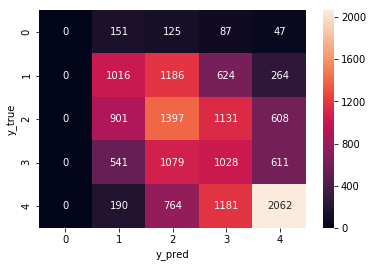

In [53]:
params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'max_bin': 512,
          'num_leaves': 30,
          'max_depth': 6,
          'min_data_in_leaf': 10,
          'learning_rate': 0.001,
          'bagging_fraction': 0.85,
#           'feature_fraction': 0.8,
#           'min_split_gain': 0.02,
#           'min_child_weight': 0.02,
          'lambda_l2': 0.05,
          'verbosity': 1,
          'early_stop': 2000,
          'verbose_eval': 100,
          'num_rounds': 20000,
         }

results = run_cv_model(
    'lgbm', 
    train_y, train_x['RescuerID'], 
    train_f, train_ids, 
    test_f, test_ids, 
    lambda: LgbmPredictor(params, f_names), lambda: QwkOptimizer()
)

In [ ]:
results_nn = run_cv_model(
    'lgbm', 
    train_y, train_x['RescuerID'], 
    train_f, train_ids, 
    test_f, test_ids, 
    lambda: PyTorchModel(ResNet(), lr=0.01, epochs=10, batch_size=128), lambda: QwkOptimizer()
)

,value
attribute,
Type,dog
Name,NaN
Age,2
Breed1,Labrador Retriever
Breed2,Mixed Breed
Gender,Male
Color1,Brown
Color2,White
MaturitySize,medium


'This male puppy born on 16 August . I hope the animal lovers from Kuala Lumpur can help to adopt him and love and care him.'

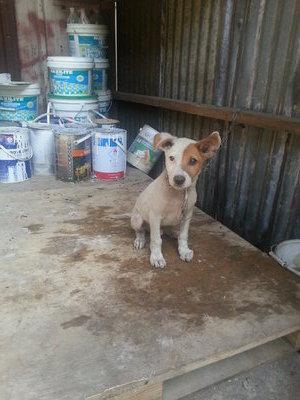

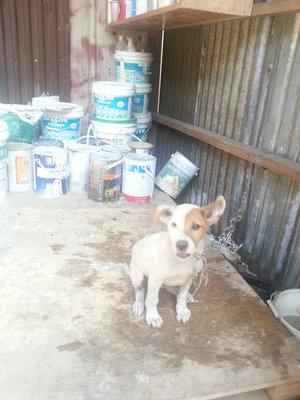

In [75]:
show_random_example(results['pred_train_y'], actual_label=4, pred_label=1)

In [58]:
display(pd.DataFrame(
    Counter(dict(zip(f_names, results['models'][0].model.feature_importance('gain')))).most_common(1000)
))

,0,1
0,cat_cols_Breed1@c,522269.862771
1,num_cols_Age,402482.410309
2,rescuer_fs_14,204774.826357
3,rescuer_fs_2,122884.939516
4,cat_cols_Sterilized@c,110548.771780
5,rescuer_fs_5,99581.900646
6,img1_fs_image1_resolution,83558.815831
7,img1_fs_image1_height,79129.563893
8,rescuer_fs_0,73710.856152
9,num_cols_Quantity,72371.487056


In [76]:
train_f, test_f, p, f_names = apply_pipeline(make_pipeline(
    FeatureUnion([
        ('desc_tokenizing', make_pipeline(
            Mapper(lambda x: list(x.Description.fillna(''))),
            CountVectorizer(
                analyzer='word',
                ngram_range=(1, 3),
                dtype=np.float32
            ),
            FeatureUnion([
                ('svd', Features(TruncatedSVD(n_components=64, random_state=SEED))),
#                 ('nmf'img_features, Features(NMF(n_components=128, random_state=SEED)))
            ])
        )),
        ('desc_text_fs', make_pipeline(
            Mapper(lambda x: list(x.Description.fillna(''))),
            TextFeatures('desc_')
        )),
        ('name_text_fs', make_pipeline(
            Mapper(lambda x: list(x.Name.fillna(''))),
            TextFeatures('name_')
        )),
        ('num_cols', Cols(num_cols)),
        ('cat_cols', CatCols(cat_cols, use_label_encoder=True)),
        ('rescuer_fs', make_pipeline(
            RescuerFeatures(num_cols=num_cols, cat_cols=cat_cols),
#             FeatureUnion([
                Features(TruncatedSVD(n_components=16, random_state=SEED)),
#                 Features(NMF(n_components=16, random_state=SEED))
#             ])
        )),
        ('entity_sents', make_pipeline(
            Mapper(lambda x: x.entity_sents),
            DictVectorizer(),
            FeatureUnion([
                ('svd', Features(TruncatedSVD(n_components=8, random_state=SEED))),
#                 ('nmf', Features(NMF(n_components=8, random_state=SEED)))
            ])
        )),
        ('img1_fs', make_pipeline(
            Mapper(lambda x: x.PetID),
            ImgFeatures(1, PF_HOME / 'train_images', PF_HOME / 'test_images'),
            Features(TruncatedSVD(n_components=8, random_state=SEED)),
        )),
    ])
), train_x, test_x)

Process ForkPoolWorker-211:
Process ForkPoolWorker-210:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-212:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-209:
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/u

,# of examples,0,1,2,3,4
fold 0: dev_y,79.96%,2.73%,20.61%,26.93%,21.74%,27.99%
fold 0: val_y,20.04%,2.76%,20.60%,26.92%,21.73%,27.99%


(11988, 144)
(3005, 144)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.15822	valid_1's rmse: 1.16428
[200]	training's rmse: 1.14182	valid_1's rmse: 1.15266
[300]	training's rmse: 1.12715	valid_1's rmse: 1.14246
[400]	training's rmse: 1.11398	valid_1's rmse: 1.13313
[500]	training's rmse: 1.10222	valid_1's rmse: 1.12492
[600]	training's rmse: 1.09169	valid_1's rmse: 1.11777
[700]	training's rmse: 1.08217	valid_1's rmse: 1.11164
[800]	training's rmse: 1.07339	valid_1's rmse: 1.10648
[900]	training's rmse: 1.06535	valid_1's rmse: 1.1022
[1000]	training's rmse: 1.05796	valid_1's rmse: 1.09819
[1100]	training's rmse: 1.05107	valid_1's rmse: 1.0948
[1200]	training's rmse: 1.04461	valid_1's rmse: 1.09188
[1300]	training's rmse: 1.03858	valid_1's rmse: 1.08907
[1400]	training's rmse: 1.03281	valid_1's rmse: 1.08635
[1500]	training's rmse: 1.02707	valid_1's rmse: 1.08392
[1600]	training's rmse: 1.02151	valid_1's rmse: 1.08157
[1700]	training's rmse: 1.01633	valid_1's rmse: 1.0

,# of examples,0,1,2,3,4
fold 1: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 1: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 144)
(2994, 144)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.15778	valid_1's rmse: 1.16187
[200]	training's rmse: 1.14067	valid_1's rmse: 1.14979
[300]	training's rmse: 1.12566	valid_1's rmse: 1.13964
[400]	training's rmse: 1.11242	valid_1's rmse: 1.13158
[500]	training's rmse: 1.10052	valid_1's rmse: 1.12487
[600]	training's rmse: 1.08986	valid_1's rmse: 1.11952
[700]	training's rmse: 1.08007	valid_1's rmse: 1.1147
[800]	training's rmse: 1.07114	valid_1's rmse: 1.11047
[900]	training's rmse: 1.06289	valid_1's rmse: 1.10694
[1000]	training's rmse: 1.0553	valid_1's rmse: 1.10369
[1100]	training's rmse: 1.04833	valid_1's rmse: 1.10095
[1200]	training's rmse: 1.04168	valid_1's rmse: 1.09824
[1300]	training's rmse: 1.03538	valid_1's rmse: 1.09612
[1400]	training's rmse: 1.02942	valid_1's rmse: 1.09406
[1500]	training's rmse: 1.02369	valid_1's rmse: 1.09218
[1600]	training's rmse: 1.0182	valid_1's rmse: 1.09153
[1700]	training's rmse: 1.0

,# of examples,0,1,2,3,4
fold 2: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 2: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 144)
(2994, 144)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.1577	valid_1's rmse: 1.16156
[200]	training's rmse: 1.14087	valid_1's rmse: 1.14909
[300]	training's rmse: 1.12616	valid_1's rmse: 1.13859
[400]	training's rmse: 1.11298	valid_1's rmse: 1.12952
[500]	training's rmse: 1.10133	valid_1's rmse: 1.12159
[600]	training's rmse: 1.09074	valid_1's rmse: 1.11461
[700]	training's rmse: 1.08105	valid_1's rmse: 1.10819
[800]	training's rmse: 1.07201	valid_1's rmse: 1.10279
[900]	training's rmse: 1.06378	valid_1's rmse: 1.09828
[1000]	training's rmse: 1.05613	valid_1's rmse: 1.09466
[1100]	training's rmse: 1.04893	valid_1's rmse: 1.0912
[1200]	training's rmse: 1.0422	valid_1's rmse: 1.08824
[1300]	training's rmse: 1.03597	valid_1's rmse: 1.08573
[1400]	training's rmse: 1.02999	valid_1's rmse: 1.0832
[1500]	training's rmse: 1.02424	valid_1's rmse: 1.08089
[1600]	training's rmse: 1.0187	valid_1's rmse: 1.07904
[1700]	training's rmse: 1.013

,# of examples,0,1,2,3,4
fold 3: dev_y,80.02%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 3: val_y,19.98%,2.74%,20.63%,26.94%,21.73%,27.97%


(11997, 144)
(2996, 144)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.15709	valid_1's rmse: 1.16206
[200]	training's rmse: 1.13967	valid_1's rmse: 1.15001
[300]	training's rmse: 1.12445	valid_1's rmse: 1.13974
[400]	training's rmse: 1.11107	valid_1's rmse: 1.13099
[500]	training's rmse: 1.09928	valid_1's rmse: 1.12395
[600]	training's rmse: 1.08846	valid_1's rmse: 1.11817
[700]	training's rmse: 1.07864	valid_1's rmse: 1.11296
[800]	training's rmse: 1.06958	valid_1's rmse: 1.10846
[900]	training's rmse: 1.06123	valid_1's rmse: 1.10447
[1000]	training's rmse: 1.05353	valid_1's rmse: 1.10111
[1100]	training's rmse: 1.04647	valid_1's rmse: 1.09821
[1200]	training's rmse: 1.03985	valid_1's rmse: 1.09557
[1300]	training's rmse: 1.03368	valid_1's rmse: 1.09323
[1400]	training's rmse: 1.02777	valid_1's rmse: 1.09106
[1500]	training's rmse: 1.02214	valid_1's rmse: 1.08922
[1600]	training's rmse: 1.01678	valid_1's rmse: 1.08748
[1700]	training's rmse: 

,# of examples,0,1,2,3,4
fold 4: dev_y,79.96%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 4: val_y,20.04%,2.76%,20.61%,26.93%,21.74%,27.96%


(11989, 144)
(3004, 144)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.15671	valid_1's rmse: 1.16308
[200]	training's rmse: 1.13938	valid_1's rmse: 1.15146
[300]	training's rmse: 1.1243	valid_1's rmse: 1.14163
[400]	training's rmse: 1.11087	valid_1's rmse: 1.13359
[500]	training's rmse: 1.09872	valid_1's rmse: 1.12553
[600]	training's rmse: 1.08782	valid_1's rmse: 1.11896
[700]	training's rmse: 1.07801	valid_1's rmse: 1.11338
[800]	training's rmse: 1.06907	valid_1's rmse: 1.10846
[900]	training's rmse: 1.06097	valid_1's rmse: 1.10439
[1000]	training's rmse: 1.05346	valid_1's rmse: 1.10095
[1100]	training's rmse: 1.04642	valid_1's rmse: 1.09804
[1200]	training's rmse: 1.03982	valid_1's rmse: 1.09578
[1300]	training's rmse: 1.03349	valid_1's rmse: 1.09374
[1400]	training's rmse: 1.02744	valid_1's rmse: 1.09214
[1500]	training's rmse: 1.02175	valid_1's rmse: 1.09056
[1600]	training's rmse: 1.0163	valid_1's rmse: 1.08939
[1700]	training's rmse: 1.

,dev cv rmse,val cv rmse,dev cv qwk,val cv qwk
lgbm - fold 0,0.822,1.056,0.735,0.413
lgbm - fold 1,0.837,1.075,0.716,0.389
lgbm - fold 2,0.867,1.064,0.691,0.413
lgbm - fold 3,0.847,1.069,0.711,0.406
lgbm - fold 4,0.913,1.079,0.649,0.367


,params,dev cv rmse (avg),dev cv rmse (std),val cv rmse (avg),val cv rmse (std),dev cv qwk (avg),dev cv qwk (std),val cv qwk (avg),val cv qwk (std),train set qwk
lgbm,,0.857,0.031,1.068,0.008,0.701,0.029,0.397,0.018,0.399


,0,1,2,3,4
train_y,2.73%,20.61%,26.93%,21.74%,27.99%
pred_train_y,0.00%,19.98%,28.40%,28.88%,22.74%
pred_test_y,0.00%,21.12%,28.50%,28.93%,21.45%


Saving to path `predictions/lgbm-24.csv`


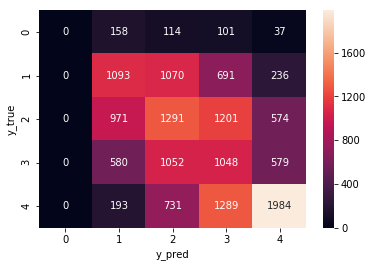

In [77]:
params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'max_bin': 512,
          'num_leaves': 30,
          'max_depth': 6,
          'min_data_in_leaf': 10,
          'learning_rate': 0.001,
          'bagging_fraction': 0.85,
#           'feature_fraction': 0.8,
#           'min_split_gain': 0.02,
#           'min_child_weight': 0.02,
          'lambda_l2': 0.05,
          'verbosity': 1,
          'early_stop': 2000,
          'verbose_eval': 100,
          'num_rounds': 20000,
         }

results2 = run_cv_model(
    'lgbm', 
    train_y, train_x['RescuerID'], 
    train_f, train_ids, 
    test_f, test_ids, 
    lambda: LgbmPredictor(params, f_names), lambda: QwkOptimizer()
)

In [80]:
display(pd.DataFrame(
    Counter(dict(zip(f_names, results2['models'][0].model.feature_importance('gain')))).most_common(1000)
))

,0,1
0,cat_cols_Breed1@c,539247.510240
1,num_cols_Age,406283.563813
2,rescuer_fs_14,198969.057510
3,rescuer_fs_2,118307.150263
4,cat_cols_Sterilized@c,110885.191917
5,rescuer_fs_5,101523.335722
6,img1_fs_0,88882.145753
7,img1_fs_1,88341.012231
8,num_cols_Quantity,75672.583133
9,cat_cols_Breed2@c,74995.354254


,# of examples,0,1,2,3,4
fold 0: dev_y,79.96%,2.73%,20.61%,26.93%,21.74%,27.99%
fold 0: val_y,20.04%,2.76%,20.60%,26.92%,21.73%,27.99%


(11988, 144)
(3005, 144)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.15822	valid_1's rmse: 1.16428
[200]	training's rmse: 1.14182	valid_1's rmse: 1.15266
[300]	training's rmse: 1.12715	valid_1's rmse: 1.14246
[400]	training's rmse: 1.11398	valid_1's rmse: 1.13313
[500]	training's rmse: 1.10222	valid_1's rmse: 1.12492
[600]	training's rmse: 1.09169	valid_1's rmse: 1.11777
[700]	training's rmse: 1.08217	valid_1's rmse: 1.11164
[800]	training's rmse: 1.07339	valid_1's rmse: 1.10648
[900]	training's rmse: 1.06535	valid_1's rmse: 1.1022
[1000]	training's rmse: 1.05796	valid_1's rmse: 1.09819
[1100]	training's rmse: 1.05107	valid_1's rmse: 1.0948
[1200]	training's rmse: 1.04461	valid_1's rmse: 1.09188
[1300]	training's rmse: 1.03858	valid_1's rmse: 1.08907
[1400]	training's rmse: 1.03281	valid_1's rmse: 1.08635
[1500]	training's rmse: 1.02707	valid_1's rmse: 1.08392
[1600]	training's rmse: 1.02151	valid_1's rmse: 1.08157
[1700]	training's rmse: 1.

,# of examples,0,1,2,3,4
fold 1: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 1: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 144)
(2994, 144)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.15778	valid_1's rmse: 1.16187
[200]	training's rmse: 1.14067	valid_1's rmse: 1.14979
[300]	training's rmse: 1.12566	valid_1's rmse: 1.13964
[400]	training's rmse: 1.11242	valid_1's rmse: 1.13158
[500]	training's rmse: 1.10052	valid_1's rmse: 1.12487
[600]	training's rmse: 1.08986	valid_1's rmse: 1.11952
[700]	training's rmse: 1.08007	valid_1's rmse: 1.1147
[800]	training's rmse: 1.07114	valid_1's rmse: 1.11047
[900]	training's rmse: 1.06289	valid_1's rmse: 1.10694
[1000]	training's rmse: 1.0553	valid_1's rmse: 1.10369
[1100]	training's rmse: 1.04833	valid_1's rmse: 1.10095
[1200]	training's rmse: 1.04168	valid_1's rmse: 1.09824
[1300]	training's rmse: 1.03538	valid_1's rmse: 1.09612
[1400]	training's rmse: 1.02942	valid_1's rmse: 1.09406
[1500]	training's rmse: 1.02369	valid_1's rmse: 1.09218
[1600]	training's rmse: 1.0182	valid_1's rmse: 1.09153
[1700]	training's rmse: 1.0

,# of examples,0,1,2,3,4
fold 2: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 2: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 144)
(2994, 144)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.1577	valid_1's rmse: 1.16156
[200]	training's rmse: 1.14087	valid_1's rmse: 1.14909
[300]	training's rmse: 1.12616	valid_1's rmse: 1.13859
[400]	training's rmse: 1.11298	valid_1's rmse: 1.12952
[500]	training's rmse: 1.10133	valid_1's rmse: 1.12159
[600]	training's rmse: 1.09074	valid_1's rmse: 1.11461
[700]	training's rmse: 1.08105	valid_1's rmse: 1.10819
[800]	training's rmse: 1.07201	valid_1's rmse: 1.10279
[900]	training's rmse: 1.06378	valid_1's rmse: 1.09828
[1000]	training's rmse: 1.05613	valid_1's rmse: 1.09466
[1100]	training's rmse: 1.04893	valid_1's rmse: 1.0912
[1200]	training's rmse: 1.0422	valid_1's rmse: 1.08824
[1300]	training's rmse: 1.03597	valid_1's rmse: 1.08573
[1400]	training's rmse: 1.02999	valid_1's rmse: 1.0832
[1500]	training's rmse: 1.02424	valid_1's rmse: 1.08089
[1600]	training's rmse: 1.0187	valid_1's rmse: 1.07904
[1700]	training's rmse: 1.013

,# of examples,0,1,2,3,4
fold 3: dev_y,80.02%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 3: val_y,19.98%,2.74%,20.63%,26.94%,21.73%,27.97%


(11997, 144)
(2996, 144)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.15709	valid_1's rmse: 1.16206
[200]	training's rmse: 1.13967	valid_1's rmse: 1.15001
[300]	training's rmse: 1.12445	valid_1's rmse: 1.13974
[400]	training's rmse: 1.11107	valid_1's rmse: 1.13099
[500]	training's rmse: 1.09928	valid_1's rmse: 1.12395
[600]	training's rmse: 1.08846	valid_1's rmse: 1.11817
[700]	training's rmse: 1.07864	valid_1's rmse: 1.11296
[800]	training's rmse: 1.06958	valid_1's rmse: 1.10846
[900]	training's rmse: 1.06123	valid_1's rmse: 1.10447
[1000]	training's rmse: 1.05353	valid_1's rmse: 1.10111
[1100]	training's rmse: 1.04647	valid_1's rmse: 1.09821
[1200]	training's rmse: 1.03985	valid_1's rmse: 1.09557
[1300]	training's rmse: 1.03368	valid_1's rmse: 1.09323
[1400]	training's rmse: 1.02777	valid_1's rmse: 1.09106
[1500]	training's rmse: 1.02214	valid_1's rmse: 1.08922
[1600]	training's rmse: 1.01678	valid_1's rmse: 1.08748
[1700]	training's rmse: 

,# of examples,0,1,2,3,4
fold 4: dev_y,79.96%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 4: val_y,20.04%,2.76%,20.61%,26.93%,21.74%,27.96%


(11989, 144)
(3004, 144)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.15671	valid_1's rmse: 1.16308
[200]	training's rmse: 1.13938	valid_1's rmse: 1.15146
[300]	training's rmse: 1.1243	valid_1's rmse: 1.14163
[400]	training's rmse: 1.11087	valid_1's rmse: 1.13359
[500]	training's rmse: 1.09872	valid_1's rmse: 1.12553
[600]	training's rmse: 1.08782	valid_1's rmse: 1.11896
[700]	training's rmse: 1.07801	valid_1's rmse: 1.11338
[800]	training's rmse: 1.06907	valid_1's rmse: 1.10846
[900]	training's rmse: 1.06097	valid_1's rmse: 1.10439
[1000]	training's rmse: 1.05346	valid_1's rmse: 1.10095
[1100]	training's rmse: 1.04642	valid_1's rmse: 1.09804
[1200]	training's rmse: 1.03982	valid_1's rmse: 1.09578
[1300]	training's rmse: 1.03349	valid_1's rmse: 1.09374
[1400]	training's rmse: 1.02744	valid_1's rmse: 1.09214
[1500]	training's rmse: 1.02175	valid_1's rmse: 1.09056
[1600]	training's rmse: 1.0163	valid_1's rmse: 1.08939
[1700]	training's rmse: 1.

,dev cv rmse,val cv rmse,dev cv qwk,val cv qwk
lgbm - fold 0,0.822,1.056,0.741,0.431
lgbm - fold 1,0.837,1.075,0.720,0.384
lgbm - fold 2,0.867,1.064,0.697,0.404
lgbm - fold 3,0.847,1.069,0.715,0.402
lgbm - fold 4,0.913,1.079,0.652,0.383


,params,dev cv rmse (avg),dev cv rmse (std),val cv rmse (avg),val cv rmse (std),dev cv qwk (avg),dev cv qwk (std),val cv qwk (avg),val cv qwk (std),train set qwk
lgbm,,0.857,0.031,1.068,0.008,0.705,0.030,0.401,0.017,0.401


,0,1,2,3,4
train_y,2.73%,20.61%,26.93%,21.74%,27.99%
pred_train_y,2.74%,20.61%,26.92%,21.74%,27.99%
pred_test_y,2.74%,20.62%,26.93%,21.73%,27.99%


Saving to path `predictions/lgbm-29.csv`


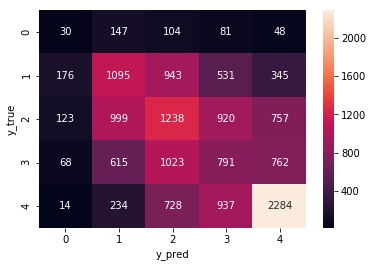

In [102]:
params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'max_bin': 512,
          'num_leaves': 30,
          'max_depth': 6,
          'min_data_in_leaf': 10,
          'learning_rate': 0.001,
          'bagging_fraction': 0.85,
#           'feature_fraction': 0.8,
#           'min_split_gain': 0.02,
#           'min_child_weight': 0.02,
          'lambda_l2': 0.05,
          'verbosity': 1,
          'early_stop': 2000,
          'verbose_eval': 100,
          'num_rounds': 20000,
         }

results3 = run_cv_model(
    'lgbm', 
    train_y, train_x['RescuerID'], 
    train_f, train_ids, 
    test_f, test_ids, 
    lambda: LgbmPredictor(params, f_names), lambda: TrainingSetDistributionPredictor()
)